In [1]:
import torch
import clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import glob
import pickle
import numpy as np 
import os
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.io as sio
from resmem import ResMem, transformer
import matplotlib.image as mpimg
from pathlib import Path
import seaborn as sns 
from scipy import stats
import re

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

C:\Users\User\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Loading Data


In [2]:
# loading data to df
mat_contents_negative = sio.loadmat('negative_study_data.mat')
# TODO : change path to neutral 
mat_contents_neutral = sio.loadmat('neutral_study_data.mat')

columns = ['subject number', 'block number', 'trial number',
           'trial duration', 'trial net duration', 'pic group',
           'pic idx', 'word list', 'word idx',
           'age', 'is female', 'is remember', 'is list 2'
           , 'after word', 'picture valance', 'RT', 'target']

df_negative = pd.DataFrame(mat_contents_negative['total_data'], columns=columns)
df_neutral = pd.DataFrame(mat_contents_neutral['total_data'], columns=columns)

words = pd.read_csv("words_info.csv")


col_list = ["image1", "image2","image_type","sim_level_sum"]
similarity = pd.read_csv("real_pairs_similarity_VGG.csv",usecols=col_list)

In [3]:
negative_words_target = pd.read_csv('negative words target.csv')
neutral_words_target = pd.read_csv('neutral words target.csv')

negative_words_target['Study words'] = negative_words_target['Study words'].str.replace("'", "")
neutral_words_target['Study words'] = neutral_words_target['Study words'].str.replace("'", "")

# Cleaning Up 

In [4]:
def d2(number):
    return "{:02d}".format(number)


def format_pic_idx(df, neutral):
    
    if neutral:
        idx = '1'
    else:
        idx = '2'
        
    df['pic group'] = df['pic group'].map(int).apply(d2)
    df['pic idx'] = df['pic idx'].map(int).apply(d2)
    df['pic idx'] = idx + df['pic group'].map(str) + df['pic idx'].map(str)
    
    df['word list'] = df['word list'].map(int).apply(d2)
    df['word idx'] = df['word idx'].map(int).apply(d2)
    df['word idx'] = df['word list'] + df['word idx']
    return df

In [5]:
df_negative = format_pic_idx(df_negative,neutral = False)
df_neutral = format_pic_idx(df_neutral,neutral = True)

In [6]:
df_negative = df_negative.drop(['trial duration', 'trial net duration', 'pic group','block number','word list'], axis = 1)
df_neutral = df_neutral.drop(['trial duration', 'trial net duration', 'pic group','block number','word list'], axis = 1)

## Adding word features 

In [7]:
words['List'] = words['List'].map(int).apply(d2)
words['Index'] = words['Index'].map(int).apply(d2)
words['Index'] = words['List'] + words['Index']
words = words.drop(['List'], axis = 1)

In [8]:
#dic_word_name = dict(words['Index']:words['word'])
dic_word_names = dict(zip(words['Index'],words['word']))
dic_word_freq = dict(zip(words['Index'],words['frequency']))
dic_word_num_letters = dict(zip(words['Index'],words['number of letters']))
dic_word_syllable = dict(zip(words['Index'],words['syllable']))
dic_word_val = dict(zip(words['Index'],words['Valance']))

In [9]:
df_negative['word name'] = df_negative['word idx'].map(dic_word_names)
df_negative['word frequency'] = df_negative['word idx'].map(dic_word_freq)
df_negative['word num letters'] = df_negative['word idx'].map(dic_word_num_letters)
df_negative['word syllable'] = df_negative['word idx'].map(dic_word_syllable)
df_negative['word valance'] = df_negative['word idx'].map(dic_word_val)


df_neutral['word name'] = df_neutral['word idx'].map(dic_word_names)
df_neutral['word frequency'] = df_neutral['word idx'].map(dic_word_freq)
df_neutral['word num letters'] = df_neutral['word idx'].map(dic_word_num_letters)
df_neutral['word syllable'] = df_neutral['word idx'].map(dic_word_syllable)
df_neutral['word valance'] = df_neutral['word idx'].map(dic_word_val)


## Adding target words

In [10]:
total_target_neutral = pd.Series([])

for idx in df_neutral['subject number'].unique():

    dic = dict(zip(neutral_words_target[neutral_words_target['Subject number'] == idx]['Study words']
                   ,neutral_words_target[neutral_words_target['Subject number'] == idx]['Word recall result day 1']))

    current_ser = df_neutral[df_neutral['subject number'] == idx]['word name'].map(dic)


    total_target_neutral = pd.concat([total_target_neutral, current_ser], ignore_index=True)
    

    
total_target_negative = pd.Series([])
    
for idx in df_negative['subject number'].unique():

    dic = dict(zip(negative_words_target[negative_words_target['Subject number'] == idx]['Study words']
                   ,negative_words_target[negative_words_target['Subject number'] == idx]['Word recall result day 1']))

    current_ser = df_negative[df_negative['subject number'] == idx]['word name'].map(dic)


    total_target_negative = pd.concat([total_target_negative, current_ser], ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_18572\2223053639.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_target_neutral = pd.Series([])
C:\Users\User\AppData\Local\Temp\ipykernel_18572\2223053639.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_target_negative = pd.Series([])


In [11]:
df_neutral['target words'] = total_target_neutral
df_negative['target words'] = total_target_negative

In [69]:
subject_number = []
acc_list1_pic = []
acc_list1_words = []
acc_list2_pic = []
acc_list2_words = []

for subject in df_neutral['subject number'].unique():
    
    subject_number.append(subject)
    current_subject = df_neutral[df_neutral['subject number'] == subject]
    total_trials_1 = len(current_subject[current_subject['is list 2'] == 0])
    total_hit_1_pic = sum(current_subject[current_subject['is list 2'] == 0]['target']== 1)
    total_hit_1_words = sum(current_subject[current_subject['is list 2'] == 0]['target words']== 1)
    acc_1_pic = total_hit_1_pic / total_trials_1
    acc_1_words = total_hit_1_words / total_trials_1
    acc_list1_pic.append(acc_1_pic)
    acc_list1_words.append(acc_1_words)
    
    current_subject = df_neutral[df_neutral['subject number'] == subject]
    total_trials_2 = len(current_subject[current_subject['is list 2'] == 1])
    total_hit_2_pic = sum(current_subject[current_subject['is list 2'] == 1]['target']== 1)
    total_hit_2_words = sum(current_subject[current_subject['is list 2'] == 1]['target words']== 1)
    acc_2_pic = total_hit_2_pic / total_trials_2
    acc_2_words = total_hit_2_words / total_trials_2
    acc_list2_pic.append(acc_2_pic)
    acc_list2_words.append(acc_2_words)
    
sanity_check_neutral = pd.DataFrame(list(zip(acc_list1_pic, acc_list2_pic,acc_list1_words,acc_list2_words))
                                    ,columns =['acc list 1 pic', 'acc list 2 pic','acc list 1 words','acc list 2 words'],
                                    index = subject_number)



subject_number = []
acc_list1_pic = []
acc_list1_words = []
acc_list2_pic = []
acc_list2_words = []

for subject in df_negative['subject number'].unique():
    
    subject_number.append(subject)
    current_subject = df_negative[df_negative['subject number'] == subject]
    total_trials_1 = len(current_subject[current_subject['is list 2'] == 0])
    total_hit_1_pic = sum(current_subject[current_subject['is list 2'] == 0]['target']== 1)
    total_hit_1_words = sum(current_subject[current_subject['is list 2'] == 0]['target words']== 1)
    acc_1_pic = total_hit_1_pic / total_trials_1
    acc_1_words = total_hit_1_words / total_trials_1
    acc_list1_pic.append(acc_1_pic)
    acc_list1_words.append(acc_1_words)
    
    current_subject = df_negative[df_negative['subject number'] == subject]
    total_trials_2 = len(current_subject[current_subject['is list 2'] == 1])
    total_hit_2_pic = sum(current_subject[current_subject['is list 2'] == 1]['target']== 1)
    total_hit_2_words = sum(current_subject[current_subject['is list 2'] == 1]['target words']== 1)
    acc_2_pic = total_hit_2_pic / total_trials_2
    acc_2_words = total_hit_2_words / total_trials_2
    acc_list2_pic.append(acc_2_pic)
    acc_list2_words.append(acc_2_words)
    
sanity_check_negative = pd.DataFrame(list(zip(acc_list1_pic, acc_list2_pic,acc_list1_words,acc_list2_words))
                                    ,columns =['acc list 1 pic', 'acc list 2 pic','acc list 1 words','acc list 2 words']
                                     ,index = subject_number)

In [72]:

sanity_check_negative.to_csv('sanity_negative.csv')
sanity_check_neutral.to_csv('sanity_neutral.csv')

## Combining negative and neutral

In [12]:
total_df = pd.concat([df_negative, df_neutral])

In [13]:
total_df

,subject number,trial number,pic idx,word idx,age,is female,is remember,is list 2,after word,picture valance,RT,target,word name,word frequency,word num letters,word syllable,word valance,target words
0,12.0,32.0,20101,0112,24.0,1.0,0.0,1.0,0.0,1.0,1248.0,1.0,דפדפת,1,5,3,2.312500,0
1,12.0,29.0,20202,0103,24.0,1.0,0.0,1.0,1.0,3.0,1343.0,1.0,דיג,5,3,2,2.520833,1
2,12.0,19.0,20203,0109,24.0,1.0,0.0,1.0,0.0,1.0,1365.0,1.0,חמאה,21,4,2,2.937500,0
3,12.0,25.0,20104,0208,24.0,1.0,0.0,1.0,1.0,1.0,1970.0,1.0,שדכן,1,4,2,2.729167,0
4,12.0,7.0,20105,0206,24.0,1.0,0.0,0.0,1.0,1.0,1036.0,1.0,תירס,11,4,2,1.375000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,45.0,14.0,10260,0116,23.0,1.0,0.0,0.0,1.0,5.0,1049.0,1.0,מקלדת,7,5,3,1.562500,0
2556,45.0,20.0,10261,0216,23.0,1.0,0.0,1.0,1.0,5.0,1019.0,1.0,מכללה,7,5,3,3.250000,1
2557,45.0,19.0,10162,0102,23.0,1.0,0.0,1.0,1.0,4.0,1083.0,1.0,כתר,15,3,2,1.916667,1
2558,45.0,2.0,10263,0208,23.0,1.0,0.0,0.0,0.0,3.0,840.0,1.0,שדכן,1,4,2,2.729167,0


## Adding similarity feature

In [14]:
# negative 
negative = similarity[similarity['image_type'] == 'negative']
neg1 = negative[['image1','sim_level_sum']]
neg2 = negative[['image2','sim_level_sum']]
neg2 = neg2.rename(columns={"image2": "image1"})
negative = pd.concat([neg1,neg2])
negative = negative.rename(columns={"image1": "idx"})



# neutral 
neutral = similarity[similarity['image_type'] == 'neutral']
nut1 = neutral[['image1','sim_level_sum']]
nut2 = neutral[['image2','sim_level_sum']]
nut2 = nut2.rename(columns={"image2": "image1"})
neutral = pd.concat([nut1,nut2])
neutral = neutral.rename(columns={"image1": "idx"})



In [15]:
def only_num_neg(string):
    
    new = re.sub("[^0-9]", "", string)
    return '2' + new 



def only_num_nut(string):
    
    new = re.sub("[^0-9]", "", string)
    return '1' + new 


negative['idx'] = negative['idx'].apply(only_num_neg)
neutral['idx'] = neutral['idx'].apply(only_num_nut)


total_similarity = pd.concat([negative,neutral])
total_similarity = dict(zip(total_similarity.idx, total_similarity.sim_level_sum))

In [16]:
total_df['similarity'] = total_df['pic idx'].map(total_similarity)

# Feature Engineering 

### Similarity score between two images:
#### Using the CLIP model, we find the feature vector for each image and calculate the cosine similarity between them.
https://openai.com/blog/clip/


##### Defining the clip function

In [ ]:
def clip_model(image1, image2):

    image1 = preprocess(image1).unsqueeze(0).to(device)
    image2 = preprocess(image2).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features1 = model.encode_image(image1)
        image_features2 = model.encode_image(image2)

    cos_dist = cosine_similarity(image_features1, image_features2)
    return cos_dist

##### Opening images from folders

In [ ]:
images1 = []
for filename in glob.glob(r'C:\Users\User\Desktop\memorability project\G1 negative\*.jpg'):
    im = Image.open(filename)
    images1.append(im)

images2 = []
for filename in glob.glob(r'C:\Users\User\Desktop\memorability project\G2 negative\*.jpg'):
    im = Image.open(filename)
    images2.append(im)

##### Running clip model for each pair of images

In [ ]:
total_diff = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

for i in range(len(images1)):
    assert len(images1) == len(images2), "check if there are the same amount of images in two folders"
    cos_dist = clip_model(images1[i], images2[i])
    total_diff.append(cos_dist)

results = np.squeeze(total_diff).round(3)

##### Saving results as DataFrame  

In [ ]:
tot_files_im1 = []
for x in os.listdir(r'C:\Users\User\Desktop\memorability project\G1 negative'):
    if x.endswith(".jpg"):
        # Prints only jpg file present in My Folder
        tot_files_im1.append(x)

tot_files_im2 = []
for x in os.listdir(r'C:\Users\User\Desktop\memorability project\G2 negative'):
    if x.endswith(".jpg"):
        # Prints only jpg file present in My Folder
        tot_files_im2.append(x)
        
index_names = [f'{tot_files_im1[i]} - {tot_files_im2[i]}'for i in range(len(tot_files_im2))]
# pd.set_option('display.max_rows', None)
df_similarity = pd.DataFrame(results,index_names)

##### Displaying example of results for a pair of images

In [ ]:
def display_image(path_1,path_2,image_number):
    img1 = Image.open(os.path.join(path_1, tot_files_im1[image_number]))
    img2 = Image.open(os.path.join(path_2, tot_files_im2[image_number]))
    diff = results[image_number]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[1].imshow(img2)
    ax[1].axis('off')
    new_line = '\n'
    tit = "{} {} similarity score : {:.3f} %".format(index_names[image_number], new_line, diff)
    fig.suptitle(tit, y=0.8)
    plt.show()

In [ ]:
display_image(r'C:\Users\User\Desktop\memorability project\G1 negative',r'C:\Users\User\Desktop\memorability project\G2 negative',32)

###  Memorability score
#### for each image we will create a memorability score with the help of ResMem 
https://arxiv.org/pdf/2105.10598.pdf

In [ ]:
PATH = Path(r'C:\Users\User\Desktop\memorability project')
all_paths = list(PATH.rglob('*.jpg'))

##### Creating the model 

In [ ]:
model = ResMem(pretrained=True)

##### Implementing over all images
##### This takes time, please run the next window to upload the results. 

In [ ]:
predictions = {}
idx = 0
for i in all_paths:
    
    name = str(all_paths[idx].relative_to('C:\\Users\\User\\Desktop\\memorability project\\'))
    
    # This loads your image 
    img = Image.open(i) 
    img.convert('RGB')
    # This will convert your image into RGB, for instance if it's a PNG (RGBA) or if it's black and white.

    model.eval()
    # Set the model to inference mode.

    image_x = transformer(img)
    # Run the preprocessing function
    
    # For a single image, the image must be reshaped into a batch
    # with size 1.
    # Get your prediction!
    prediction = model(image_x.view(-1, 3, 227, 227))
    prediction = prediction.data[0][0]
    predictions[name] = prediction.item()
    
    idx += 1


##### Uploading model results to DataFrame  

In [17]:
with open(r'C:\Users\User\Desktop\memorability project\memorability_predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

tot = [(a.split('\\')[0].split(' ')[-1],val) for a,val in predictions.items()]
model_memorability = pd.DataFrame(tot,columns=['valance','memorability'])

In [18]:
tot = []
for a,val in predictions.items():
    pic_idx = a.split('\\')[-1].split('.')[0]
    valance = a.split('\\')[0].split(' ')[-1]
    if valance == 'negative':
        pic_idx = '2' + pic_idx
    else:
        pic_idx = '1' + pic_idx 
    tot.append((pic_idx,val,valance))

model_memorability = pd.DataFrame(tot,columns=['pic_idx','memorability','valance'])

In [19]:
dic = dict(zip(model_memorability.pic_idx, model_memorability.memorability))

In [20]:
real_memorability_neutral = {}
for id in range(10101,10265):
    
    if 10201 > id > 10164:
        continue
        
    total_hit = sum(df_neutral[df_neutral['pic idx'] == str(id)]['target'])
    total_picture = len(df_neutral[df_neutral['pic idx'] == str(id)])
    memorability_perc = total_hit/total_picture
    real_memorability_neutral[str(id)] = memorability_perc
    

    
data_items = real_memorability_neutral.items()
data_list = list(data_items)
df_neut  = pd.DataFrame(data_list,columns = ['pic idx','memorability'])

real_memorability_negative = {}

for id in range(20101,20265):

    if 20201 > id > 20164:
        continue
    
    total_hit = sum(df_negative[df_negative['pic idx'] == str(id)]['target'])
    total_picture = len(df_negative[df_negative['pic idx'] == str(id)])
    memorability_perc = total_hit/total_picture
    real_memorability_negative[str(id)] = memorability_perc
    
data_items = real_memorability_negative.items()
data_list = list(data_items)

df_neg = pd.DataFrame(data_list,columns = ['pic idx','memorability'])   

In [21]:
study_memorability = pd.concat([df_neg,df_neut],ignore_index = True)
study_memorability['valance'] = study_memorability['pic idx'].str.startswith('1').map({True: 'neutral', False: 'negative'})

In [22]:
study_memorability['model_memorability'] = study_memorability['pic idx'].map(dic)

In [23]:
study_memorability

,pic idx,memorability,valance,model_memorability
0,20101,0.952381,negative,0.709741
1,20102,0.869565,negative,0.822072
2,20103,0.722222,negative,0.896091
3,20104,0.421053,negative,0.824198
4,20105,1.000000,negative,0.937361
...,...,...,...,...
251,10260,0.761905,neutral,0.609175
252,10261,0.800000,neutral,0.651796
253,10262,1.000000,neutral,0.805572
254,10263,0.857143,neutral,0.837362


##### plotting the distribution between the memorability for neutral and negative images  

In [24]:
score_model = stats.ttest_ind(study_memorability[study_memorability['valance']=='negative']['model_memorability'],
                        study_memorability[study_memorability['valance']=='neutral']['model_memorability'])
pval_model = round(score_model.pvalue,15)
tval_model = round(score_model.statistic,3)

score_true = stats.ttest_ind(study_memorability[study_memorability['valance']=='negative']['memorability'],
                        study_memorability[study_memorability['valance']=='neutral']['memorability'])
pval_true = round(score_true.pvalue,15)
tval_true = round(score_true.statistic,3)

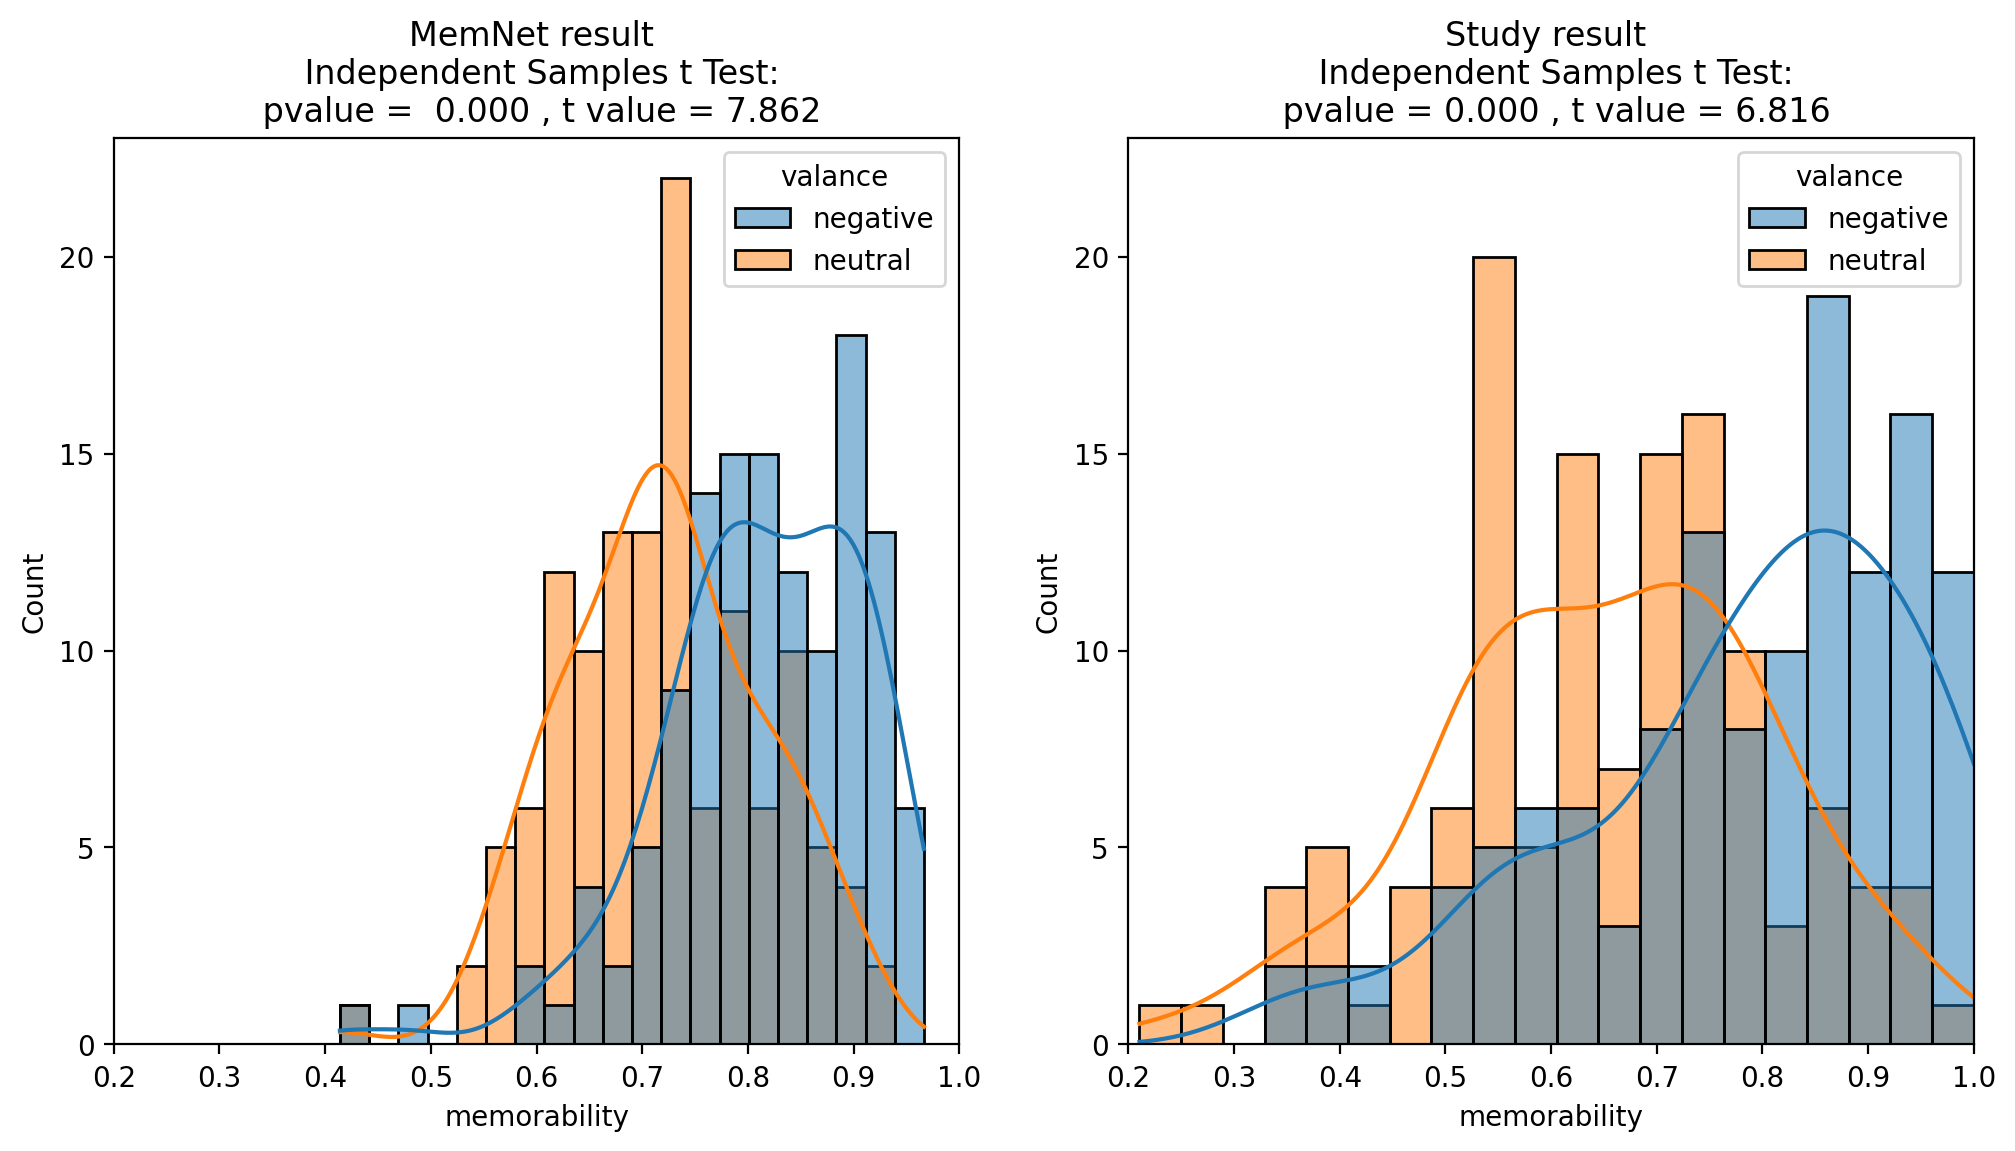

In [25]:

fig, ax = plt.subplots(1,2,figsize=(12,6),dpi = 200)
sns.histplot(ax = ax[0],data=study_memorability, x='model_memorability', hue='valance',kde=True,hue_order=['negative','neutral'],bins = 20)
sns.histplot(ax = ax[1],data=study_memorability, x='memorability', hue='valance',kde=True,hue_order=['negative','neutral'],bins  = 20)

ax[0].set_title(f'MemNet result \n Independent Samples t Test:\n pvalue =  {pval_model:.3f} , t value = {tval_model}')
ax[1].set_title(f'Study result \n Independent Samples t Test:\n pvalue = {pval_true:.3f} , t value = {tval_true}')
ax[0].set_xlabel('memorability')
ax[0].set_ylim([0,23])
ax[1].set_ylim([0,23])
ax[0].set_xlim([0.2,1])
ax[1].set_xlim([0.2,1])
plt.savefig('memorability distribution.png')

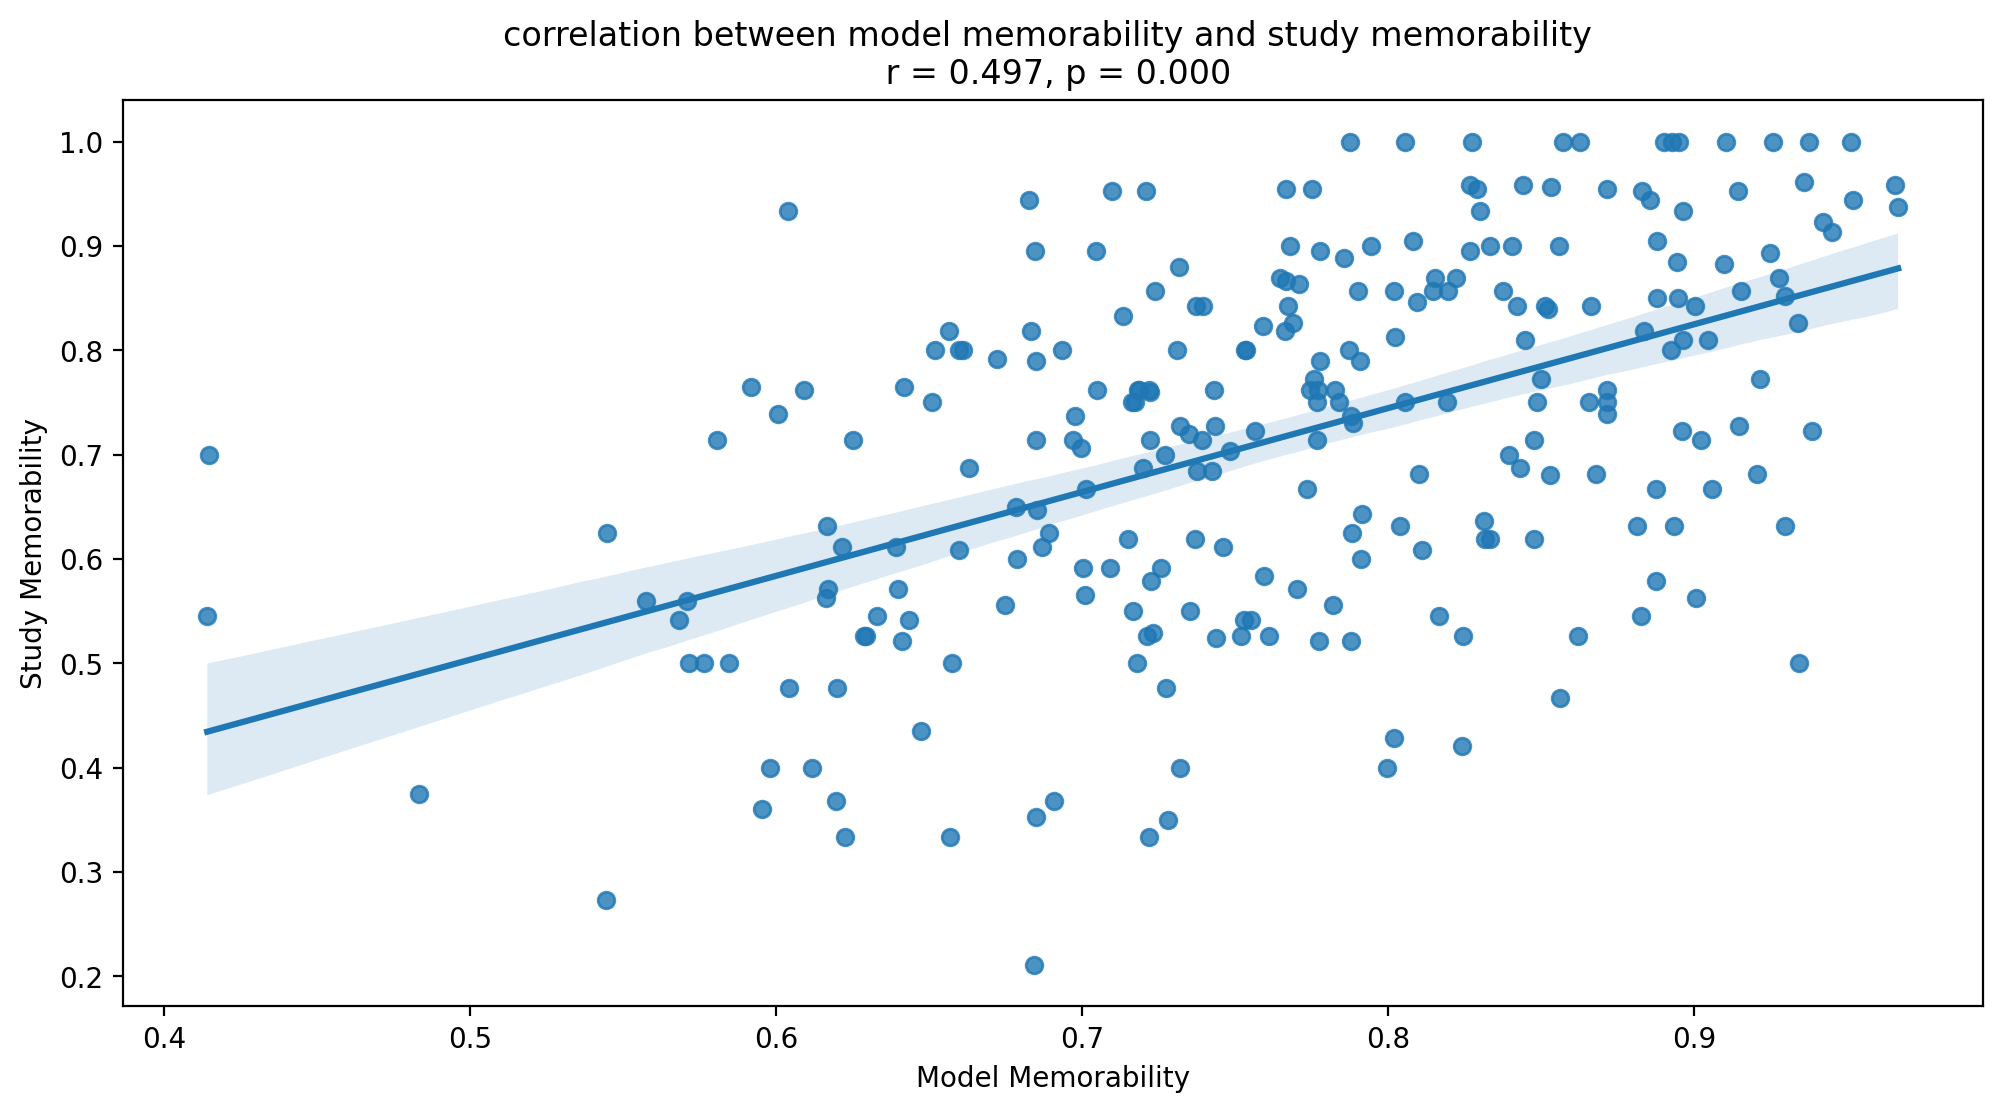

In [26]:
import scipy 

corr , p  = scipy.stats.pearsonr(study_memorability['model_memorability'],study_memorability['memorability'])

plt.figure(figsize=(12,6),dpi = 200)
sns.regplot(x = study_memorability['model_memorability'], y = study_memorability['memorability'])
plt.xlabel('Model Memorability')
plt.ylabel('Study Memorability');
plt.title(f"correlation between model memorability and study memorability \n r = {corr:.3f}, p = {p:.3f}")
plt.savefig('memorability correlation.png')

<Figure size 2000x800 with 0 Axes>

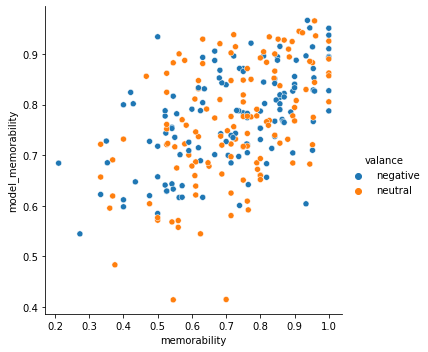

In [27]:
corr_neg , p_neg  = scipy.stats.pearsonr(study_memorability[study_memorability['valance'] == 'negative']['memorability'],
                                         study_memorability[study_memorability['valance'] == 'negative']['model_memorability'])


corr_neut , p_neut  = scipy.stats.pearsonr(study_memorability[study_memorability['valance'] == 'neutral']['memorability'],
                                         study_memorability[study_memorability['valance'] == 'neutral']['model_memorability'])

plt.figure(figsize=(10,4),dpi = 200)
sns.relplot(x = study_memorability['memorability'], y = study_memorability['model_memorability'],hue =  model_memorability['valance'])

In [28]:
print((corr_neg , p_neg))
print((corr_neut , p_neut))

(0.4779496878490154, 1.1618499402518996e-08)
(0.29712406494526117, 0.000659579778787374)


# Adding features 

#### For the memorability feature, we will create a dictionary that the keys are picture index, and values the memorability score 

In [29]:
total_df['memorability'] = total_df['pic idx'].map(dic)

#### creating a vector of similarity scores to concat to the feature matrix 

In [30]:
total_df.head(15)
total_df['target'] = total_df.target.astype(int)

In [41]:
total_df

,subject number,trial number,pic idx,word idx,age,is female,is remember,is list 2,after word,picture valance,RT,target,word name,word frequency,word num letters,word syllable,word valance,target words,similarity,memorability
0,12.0,32.0,20101,0112,24.0,1.0,0.0,1.0,0.0,1.0,1248.0,1,דפדפת,1,5,3,2.312500,0,2.013627,0.709741
1,12.0,29.0,20202,0103,24.0,1.0,0.0,1.0,1.0,3.0,1343.0,1,דיג,5,3,2,2.520833,1,1.955592,0.887480
2,12.0,19.0,20203,0109,24.0,1.0,0.0,1.0,0.0,1.0,1365.0,1,חמאה,21,4,2,2.937500,0,2.286948,0.843936
3,12.0,25.0,20104,0208,24.0,1.0,0.0,1.0,1.0,1.0,1970.0,1,שדכן,1,4,2,2.729167,0,2.408555,0.824198
4,12.0,7.0,20105,0206,24.0,1.0,0.0,0.0,1.0,1.0,1036.0,1,תירס,11,4,2,1.375000,1,2.207746,0.937361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,45.0,14.0,10260,0116,23.0,1.0,0.0,0.0,1.0,5.0,1049.0,1,מקלדת,7,5,3,1.562500,0,2.422115,0.609175
2556,45.0,20.0,10261,0216,23.0,1.0,0.0,1.0,1.0,5.0,1019.0,1,מכללה,7,5,3,3.250000,1,2.253350,0.651796
2557,45.0,19.0,10162,0102,23.0,1.0,0.0,1.0,1.0,4.0,1083.0,1,כתר,15,3,2,1.916667,1,2.268586,0.788489
2558,45.0,2.0,10263,0208,23.0,1.0,0.0,0.0,0.0,3.0,840.0,1,שדכן,1,4,2,2.729167,0,1.906375,0.837362


In [42]:
total_df['subject number'].unique()

array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 47.,
       48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60.,
       61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 72., 73., 74.,
       75., 76., 77.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40., 41., 43., 44., 45.])

## Modeling 

## Checking target balance

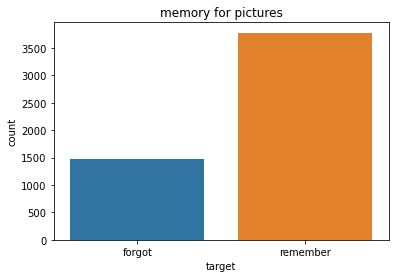

In [32]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='target', data=total_df);
ax.set_title('memory for pictures')
ax.set_xticklabels(['forgot','remember']);

[Text(0, 0, 'forgot'), Text(1, 0, 'remember')]

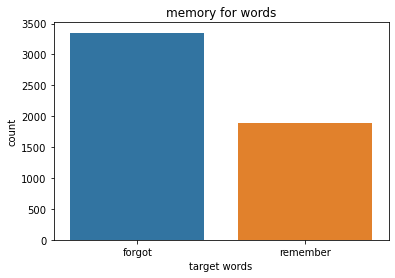

In [33]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='target words', data=total_df)
ax.set_title('memory for words')
ax.set_xticklabels(['forgot','remember'])

<AxesSubplot:xlabel='similarity', ylabel='Count'>

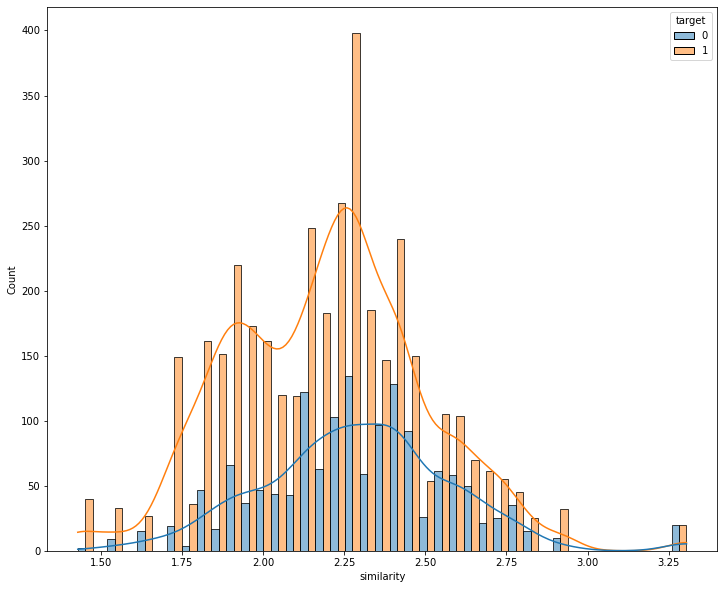

In [34]:
plt.figure(figsize=(12,10))


sns.histplot(data = total_df.reset_index(), x='similarity', hue="target", multiple="dodge",kde = 'True')


In [ ]:
plt.figure(figsize=(12,10))
sns.histplot(data = total_df.reset_index(), x='similarity', hue="target", multiple="dodge",kde = 'True')